# Pre-load

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast
import eelbrain
import mne
import trftools
from sklearn import feature_selection

In [ ]:
# Path_JRB

DATA_ROOT = Path("~").expanduser() / 'Dropbox (University of Michigan)' / 'LittlePrince_trf'

In [2]:
# Path_JC

DATA_ROOT = Path("~").expanduser() / 'Data' / 'LittlePrince'

In [3]:
# FIRST chapter of LPP divided into 11 wav files

STIMULI = [str(i) for i in range(1, 12)]
PREDICTOR_DIR = DATA_ROOT / 'predictors'
EEG_DIR = DATA_ROOT / 'eeg'

# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs'
TRF_DIR.mkdir(exist_ok=True)

In [4]:
# Load stimuli
# ------------
# Make sure to name the stimuli so that the TRFs can later be distinguished
# Load the gammatone-spectrograms; use the time axis of these as reference
gammatone = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-8.pickle') for stimulus in STIMULI]

# Resample the spectrograms to 100 Hz (time-step = 0.01 s), which we will use for TRFs
gammatone = [x.bin(0.01, dim='time', label='start') for x in gammatone]

# Pad onset with 100 ms and offset with 1 second; make sure to give the predictor a unique name as that will make it easier to identify the TRF later
gammatone = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='gammatone') for x in gammatone]

# Load the broad-band envelope and process it in the same way
envelope = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-1.pickle') for stimulus in STIMULI]
envelope = [x.bin(0.01, dim='time', label='start') for x in envelope]
envelope = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='envelope') for x in envelope]
onset_envelope = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-on-1.pickle') for stimulus in STIMULI]
onset_envelope = [x.bin(0.01, dim='time', label='start') for x in onset_envelope]
onset_envelope = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='onset') for x in onset_envelope]

# Load onset spectrograms and make sure the time dimension is equal to the gammatone spectrograms
gammatone_onsets = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-on-8.pickle') for stimulus in STIMULI]
gammatone_onsets = [x.bin(0.01, dim='time', label='start') for x in gammatone_onsets]
gammatone_onsets = [eelbrain.set_time(x, gt.time, name='gammatone_on') for x, gt in zip(gammatone_onsets, gammatone)]

# Load word tables and convert tables into continuous time-series with matching time dimension
#word_tables = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~word.pickle') for stimulus in STIMULI]
#word_onsets = [eelbrain.event_impulse_predictor(gt.time, ds=ds, name='word') for gt, ds in zip(gammatone, word_tables)]

# Function and content word impulses based on the boolean variables in the word-tables
#word_lexical = [eelbrain.event_impulse_predictor(gt.time, value='lexical', ds=ds, name='lexical') for gt, ds in zip(gammatone, word_tables)]
#word_nlexical = [eelbrain.event_impulse_predictor(gt.time, value='nlexical', ds=ds, name='non_lexical') for gt, ds in zip(gammatone, word_tables)]

# Extract the duration of the stimuli, so we can later match the EEG to the stimuli
durations = [gt.time.tmax for stimulus, gt in zip(STIMULI, gammatone)]


In [5]:
# Models
# ------
# Pre-define models here to have easier access during estimation. In the future, additional models could be added here and the script re-run to generate additional TRFs.
models = {
    # Acoustic models
    'envelope': [envelope],
#    'envelope+onset': [envelope, onset_envelope],
#    'acoustic': [gammatone, gammatone_onsets],
    # Models with word-onsets and word-class
#    'words': [word_onsets],
#    'words+lexical': [word_onsets, word_lexical, word_nlexical],
#    'acoustic+words': [gammatone, gammatone_onsets, word_onsets],
#    'acoustic+words+lexical': [gammatone, gammatone_onsets, word_onsets, word_lexical, word_nlexical],
}

# Load & preprocess EEG

In [7]:
df = pd.read_csv("bad_channels.csv")

subject_idx     = 1
subject         = df['subject'][subject_idx]
subject_trf_dir = TRF_DIR / subject
subject_trf_dir.mkdir(exist_ok=True)
    
# Generate all TRF paths so we can check whether any new TRFs need to be estimated
trf_paths = {model: subject_trf_dir / f'{subject} {model}.pickle' for model in models}
        
# Load the EEG data
raw = mne.io.read_raw_brainvision(EEG_DIR / subject / f'{subject}EEG_01.vhdr', preload=True)
#R0420: No S1, R0443: noisy after 553 sec, R0446: noisy, R0454: no S1

In [8]:
# Crop
#   tmin = 1 sec before aud onset, 
#   tmax = 1 sec after aud offset

events = mne.events_from_annotations(raw);

for i in range(len(events[0])):
    if events[0][i][2] == 1:
        start_first = events[0][i][0]
        break
        
for i in range(len(events[0])):
    if events[0][i][2] == 2:
        end_first = events[0][i][0]
        break

Fs            = raw.info["sfreq"]
start_pad_sec = (start_first - 1 * Fs)/Fs
end_pad_sec   = (end_first + 1 * Fs)/Fs

if start_pad_sec < 0:
    raise Exception("Crop window cannot begin before 0")

eeg = raw.copy().crop(tmin=start_pad_sec, tmax=end_pad_sec) 

In [9]:
# Filter

eeg.filter(0.5, 20)

#Rereference

eeg.add_reference_channels('29')
eeg.set_eeg_reference(ref_channels = ['25', '29'])

# Pick EEG channels

eeg = eeg.pick_types(eeg=True, meg=False, exclude=['VEOG', 'OPTO', 'AUD'])

# Set montage

montage = mne.channels.read_custom_montage(DATA_ROOT / 'easycapM10-acti61_elec.sfp')
eeg.set_montage(montage, on_missing='ignore')

C:\Users\LG\AppData\Local\Temp\ipykernel_36412\2763348194.py:17: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg.set_montage(montage, on_missing='ignore')


<RawBrainVision | R0459_20170616_LittlePrinceEEG_01.eeg, 61 x 278367 (556.7 s), ~129.6 MB, data loaded>

In [63]:
#eeg.info['ch_names']

In [23]:
%matplotlib

eeg.plot()

Using matplotlib backend: QtAgg


In [20]:
#butterfly plot
eeg.pick_types(eeg=True).plot(butterfly=True, start = 0.0, duration = 20.0, scalings = dict(eeg=100e-6));

In [10]:
# Bad channels interpolation

for ch in ast.literal_eval(df['bad_channels'][subject_idx]):
    str_ch = str(ch)
    eeg.info['bads'].append(str_ch) 

eeg.interpolate_bads()

<RawBrainVision | R0459_20170616_LittlePrinceEEG_01.eeg, 61 x 278367 (556.7 s), ~129.6 MB, data loaded>

In [ ]:
eeg.plot()

In [11]:
# ICA 

filt_raw = eeg.copy().filter(l_freq=1., h_freq=None)
ica = mne.preprocessing.ICA(n_components=25, max_iter='auto', random_state=97)
ica.fit(filt_raw)
ica

Method,fastica
Fit,41 iterations on raw data (278367 samples)
ICA components,25
Explained variance,100.0 %
Available PCA components,61
Channel types,eeg
ICA components marked for exclusion,—


In [12]:
filt_raw.load_data()
ica.plot_sources(filt_raw, show_scrollbars=True);

In [27]:
ica.plot_components()

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x260 with 5 Axes>]

In [13]:
#ica.exclude = [0, 1] #R0443
ica.exclude = [0 , 1, 2, 3, 4] #R0459
#ica.exclude = [0, 1, 2, 4] #R0462

eeg_noica = eeg.copy()
ica.apply(eeg)

<RawBrainVision | R0459_20170616_LittlePrinceEEG_01.eeg, 61 x 278367 (556.7 s), ~129.6 MB, data loaded>

In [ ]:
%matplotlib
eeg.plot()

In [73]:
eeg.pick_types(eeg=True).plot(butterfly=True, start = 0.0, duration = 20.0, scalings = dict(eeg=100e-6));

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 270, in process
    func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/mne/viz/_mpl_figure.py", line 511, in _resize
    old_width, old_height = self.mne.fig_size_px
AttributeError: 'BrowserParams' object has no attribute 'fig_size_px'


In [67]:
#eeg.save(DATA_ROOT / 'R0443_preprocessed_raw.fif', overwrite=False)

# AUD channel alignment

In [19]:
# AUD

aud = raw.copy().pick_channels(['AUD'])
#aud = aud.crop(tmin = start_pad_sec, tmax=end_pad_sec) # Option 1
aud = aud.crop(tmin = start_pad_sec, tmax=600)  # Option 2

In [19]:
end_first/Fs-start_first/Fs #will not be the smae as the actual duration of the audio stimuli
                            #Option 1: crop predictors_concatenated to match shifted eeg epoch
                            #Option 2: crop eeg to match predictors_concatenated

554.732

In [18]:
aud.times.max()

555.732

In [17]:
sum(durations)

565.42

In [15]:
predictors_concatenated[0].get_dim('time') #sum(durations) =/= predictors_concatenated[0].get_dim('time') for Alice too

UTS(0.0, 0.01, 56663)

In [15]:
# Reminder: 
# first chapter stimulus has been separated into ~1 min "trials" 
# (to facilitate gammatone creation)

trial_indexes = [int(i)-1 for i in STIMULI]
trial_durations = durations

for model, predictors in models.items():
    # Select and concetenate the predictors corresponding to the EEG trials
    predictors_concatenated = []
    for predictor in predictors:
        predictors_concatenated.append(eelbrain.concatenate([predictor[i] for i in trial_indexes]))

In [96]:
# Rough check
# predictor @100 Hz, eeg @500 Hz
# eeg has +2 seconds of padding

[predictors_concatenated, len(eeg.times)/5] 

[[<NDVar 'envelope': 56663 time>], 55673.4]

In [68]:
aud.plot()

In [49]:
# Get data from the paragraph onset
# awkward: "epoch" goes all the way to stimulus end, i.e. end_pad_sec minus 1 second padding :-/
# TODO: how to automatically determine tmax here and below for AUD?

event_id = {'onset': 1}
events   = mne.events_from_annotations(aud)
events   = events[0]
dur      = sum(durations)

epoch_aud = mne.Epochs(aud, events, event_id, 
                        tmin=-0.1, tmax=566.53,  #end_first/Fs-start_first/Fs
                        baseline=(None,0.), preload=True)

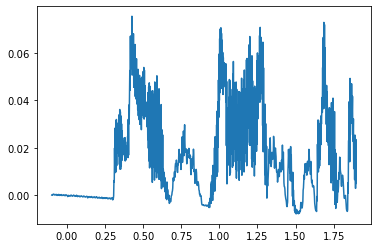

In [105]:
# AUD channel plot

y = epoch_aud.get_data()[0][0][0:1000]
t = epoch_aud.times[0:1000]
plt.plot(t, y)

In [50]:
# Resample and concatenate aud

ds_sfreq = 100

aud_downsampled = epoch_aud.copy().resample(sfreq=ds_sfreq)
aud_ndvar         = eelbrain.load.fiff.epochs_ndvar(epoch_downsampled, -0.100, connectivity='none')
aud_concatenated  = eelbrain.concatenate(aud_ndvar)

In [23]:
aud_concatenated.get_dim('time')

UTS(0.0, 0.01, 55483)

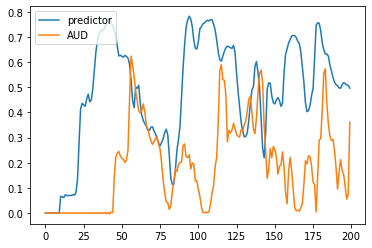

In [235]:
# Plot predictors_con and aud_con (same time intervals)

%matplotlib inline

X = range(0, 200) # X axis in 100 Hz samples
#X = range(50000, 50050)
plt.plot(X, predictors_concatenated[0].x[X]/2000, label='predictor')
plt.plot(X, aud_concatenated.x[0][X], label='AUD')
plt.legend(loc="upper left")

plt.show()

In [56]:
%matplotlib

# Plot predictors_con and aud_con (shifted time intervals)

shift_by = 25 # in 100 Hz samples
X1 = np.arange(0, 5000) # 1 sec window
X2 = X1+shift_by 

plt.plot(X1, predictors_concatenated[0].x[X1]/2000, label='predictor') #BLUE
plt.plot(X1, aud_concatenated.x[0][X2], label='AUD shifted') #ORANGE

plt.legend(loc="upper left")

plt.show()

# TODO: AUTOMATE shifting using mutual information across time lags

Using matplotlib backend: <object object at 0x0000022D4D0F7690>


In [85]:
# Find mutual information for each shifted time

events = mne.events_from_annotations(raw);
events = events[0];
mi_ls = [];

for s in range(0, 200):
    
    shift_by = s
    shift_by_sec = shift_by / ds_sfreq

    events_shft = []

    for i in range(len(events)-1):
        events_shft[i:i+1] = mne.event.shift_time_events(events[i:i+1], 
                                                         ids=None, 
                                                         tshift=shift_by_sec, 
                                                         sfreq=raw.info['sfreq'])

    events_shift_arr = np.vstack(events_shft)

    epoch_aud_shifted = mne.Epochs(aud, events_shift_arr, event_id, tmin=0, tmax=566.63, 
                                    baseline=(0,0.), preload=True)
    
    aud_shifted_downsampled = epoch_aud_shifted.copy().resample(sfreq=ds_sfreq)
    aud_shifted_rotated = np.rot90(aud_shifted_downsampled.get_data()[0])
    
    mi = feature_selection.mutual_info_regression(aud_shifted_rotated, predictors_concatenated[0]) 
    mi_ls.append(mi[0])

<function matplotlib.pyplot.show(close=None, block=None)>

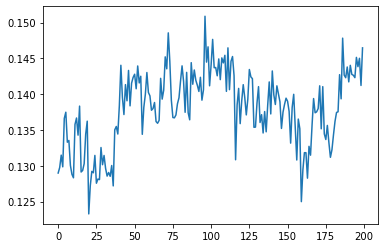

In [86]:
%matplotlib inline

plt.plot(mi_ls)
plt.show

In [59]:
# Shift aud and convert to epoch

shift_by_sec = shift_by / ds_sfreq
 
events = mne.events_from_annotations(raw);
events = events[0];
events_shft = []

# why do we need to do this in a loop?
for i in range(len(events)-1):
    events_shft[i:i+1] = mne.event.shift_time_events(events[i:i+1], 
                                                         ids=None, 
                                                         tshift=shift_by_sec, 
                                                         sfreq=raw.info['sfreq'])

events_shift_arr = np.vstack(events_shft)

epoch_aud_shifted = mne.Epochs(aud, events_shift_arr, event_id, tmin=-0.1, tmax=566.53, #end_first/Fs-start_first/Fs
                                baseline=(None,0.), preload=True)

In [137]:
# Resample and concatenate

epoch_shifted_downsampled  = epochs_aud_shifted.copy().resample(sfreq=100)
aud_shifted                = eelbrain.load.fiff.epochs_ndvar(epoch_shifted_downsampled, -0.100, connectivity='none')
aud_shifted_concatenated   = eelbrain.concatenate(aud_shifted)

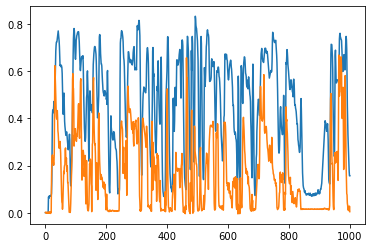

In [243]:
# Check alignment

%matplotlib inline
X = range(0, 1000)
plt.plot(X, predictors_concatenated[0].x[X]/2000)
plt.plot(X, aud_shifted_concatenated.x[0][X])

plt.show()

# Shift EEG

In [121]:
# Get data from the paragraph onset
# TODO: how to figure out tmax automatically??

event_id={'onset': 1}
epochs = mne.Epochs(eeg, events_shift_arr, event_id, tmin=-0.1, tmax=end_first/Fs-start_first/Fs, baseline=(None,0.), preload=True)

In [122]:
epochs

Number of events,1
Events,onset: 1
Time range,-0.100 – 554.732 sec
Baseline,-0.100 – 0.000 sec


In [300]:
# Resample and concatenate
eeg_epoch_downsampled     = epochs.copy().resample(sfreq=100)
eeg_shifted               = eelbrain.load.fiff.epochs_ndvar(eeg_epoch_downsampled, -0.100, connectivity='auto')
eeg_shifted_concatenated  = eelbrain.concatenate(eeg_shifted)

In [16]:
#X=range(0, 56663)
#predictors_concatenated[0].x[X]

array([0., 0., 0., ..., 0., 0., 0.])

In [142]:
sum(durations)

565.42

In [140]:
[aud_shifted_concatenated.get_dim('time'), 
 predictors_concatenated[0].get_dim("time")] 

[UTS(0.0, 0.01, 55483), UTS(0.0, 0.01, 56663)]

In [94]:
# Check we have the same number of predictor and response samples!

[eeg_shifted_concatenated.get_dim('time'), 
 predictors_concatenated[0].get_dim("time")]  # sampling rate = 100

NameError: name 'predictors_concatenated' is not defined

In [303]:
eeg_shifted_concatenated.time

UTS(0.0, 0.01, 55510)

In [312]:
# trim predictors to match EEG
# TODO: figure out cropping earlier so this isn't needed

predictors_cropped = eelbrain.set_time(predictors_concatenated[0], eeg_shifted_concatenated)

In [313]:
[eeg_shifted_concatenated.get_dim('time'), 
 predictors_cropped.get_dim("time")]  # sampling rate = 100

[UTS(0.0, 0.01, 55510), UTS(0.0, 0.01, 55510)]

In [314]:
# Fit the mTRF

eelbrain.configure(n_workers=False)

trf = eelbrain.boosting(eeg_shifted_concatenated, predictors_cropped, 
                        -0.100, 1.000, error='l1', 
                        basis=0.050, partitions=5, test=1, selective_stopping=True)
        
# Save the TRF for later analysis
eelbrain.save.pickle(trf, path)

Fitting models:   0%|          | 0/1220 [00:00<?, ?it/s]

NameError: name 'path' is not defined

In [96]:
#eelbrain.save.pickle(trf, 'C:/Users/LG/Data/LittlePrince/TRFs/R0462 shifted_envelope.pickle')

# Figure

cf. boosting result: https://eelbrain.readthedocs.io/en/stable/generated/eelbrain.BoostingResult.html

In [315]:
import re
import os
import trftools
from scipy.io import loadmat
from eelbrain import *
from matplotlib import pyplot

In [316]:
subject = 'R0462'
#trf = load.unpickle(f'C:/Users/LG/data/LittlePrince/TRFs/{subject} shifted_envelope.pickle')

In [2]:
%matplotlib inline
p = plot.TopoButterfly(trf.h, w=6, h=2, vmax = 0.01)
p.set_time(.2)

Using matplotlib backend: MacOSX


NameError: name 'plot' is not defined

Prompt-toolkit does not seem to be supported by the current IPython shell (ZMQInteractiveShell); The Eelbrain GUI needs to block Terminal input to work. Use eelbrain.gui.run() to start GUI interaction.
Starting GUI. Quit the Python application to return to the shell...


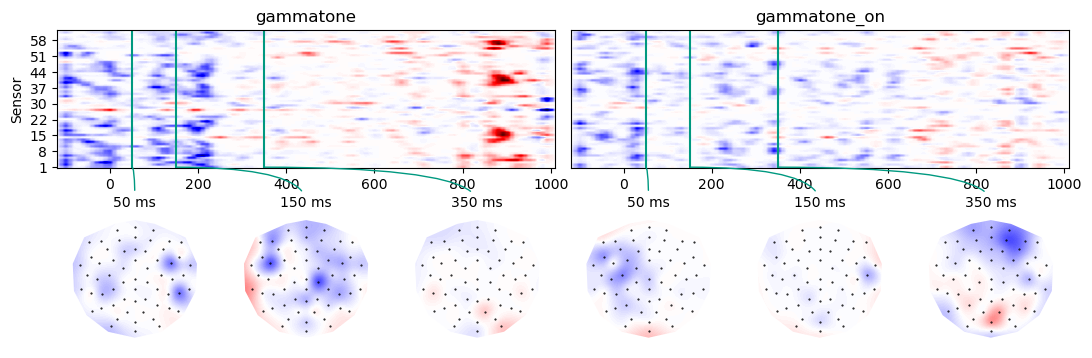

In [48]:
%matplotlib qt
plot.TopoArray(trf.h, w=6, h=2, t=(.050, .150, .350))

In [27]:
trf1 = eelbrain.load.unpickle(Path("~").expanduser() / 'Data' / 'Alice' / 'TRFs' / 'S01' / 'S01 acoustic.pickle')

In [31]:
p = plot.TopoButterfly(trf1.h_scaled, w=6, h=2)
p.set_time(.35)

ValueError: y=<NDVar 'gammatone': 61 sensor, 8 frequency, 114 time> is ambiguous for required dimensions ('sensor', None)

In [ ]:
p = plot.TopoArray(trf1.h, w=6, h=2, t=(.050, .150, .350))

Starting GUI. Quit the Python application to return to the shell...
